In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.tsatools import detrend
from functools import partial 
import xarray as xr
from thesis_toolbox.plot.tools import add_letter
from thesis_toolbox.utils import get_locations_CLP
import matplotlib.cm as cm
from matplotlib.ticker import StrMethodFormatter
from matplotlib.patches import Circle, Rectangle, Patch
import matplotlib
from itertools import product
plt.style.use('seaborn-paper')
%matplotlib inline

In [2]:
def create_bubbles(data, axi):
    img = axi.collections[0]
    vals = img.get_array().reshape(data.shape[0], data.shape[1])
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = img.norm(vals[i, j])
            radius = np.abs(vals[i, j])
            color = img.cmap(value)
            if i % 2 == 0:
                rect = Rectangle((j, i), 1, 1, color='1.0')
            else:
                rect = Rectangle((j, i), 1, 1, color='0.9')
            axi.add_artist(rect)
#             circle = Circle((j+0.5, i+0.5), radius=radius,
#                             color=color,zorder=1000)
#             axi.add_artist(circle)
            point = matplotlib.lines.Line2D([j+0.5],[i+0.5], color=color, marker='o',markersize=15*radius, linestyle='')
            axi.add_artist(point)
    img.set_visible(False)

In [3]:
if 'snakemake' in globals():
    to_file = True
    path='./'
else:
    path = '../../../'
    to_file= False

In [18]:
df = pd.read_csv(path+'results/timeseries_table.csv',index_col=0)
df = df.rename(columns={'Temp gradient anomalies MAM':'EATG MAM','Temp gradient anomalies_DJF':'EATG DJF',
                       'AO EOF MAM':'AO MAM','AO EOF DJF':'AO DJF','Jungger Basin':'Gurbantunggut',
                       'Quaidam Baisin':'Quaidam'})

df = df.drop(['NAO station MAM', 'NAO station DJF', 'Total'], axis=1)

# caob = pd.read_csv(path+'results/COAB_table.csv', index_col=0).loc[1999:]

detrend_func = partial(detrend, axis=1)
detrended=df.apply(detrend_func,raw=True)
# caob_detrended = caob.fillna(0).apply(detrend_func,raw=True)
locs = get_locations_CLP().index
locs = locs.drop('YINCHUAN')
locs = locs.drop('ULANTATAL')
locs = locs.drop('BADOE')
tloc = ['SHAPOTOU','SACOL','LUOCHUAN','LINGTAI','LANTIAN']
detrended = detrended.drop(labels=[f'Precip {loc} MAM' for loc in tloc],axis=1)
detrended = detrended.drop(labels=[f'Precip {loc} DJF' for loc in tloc],axis=1)


Remove some cluter from the table

In [19]:
remove_indicies = ['NAO EOF MAM', 'NAO EOF DJF']
detrended=detrended.drop(remove_indicies,axis=1)

Rename 20micron to silt and 2micron to clay so that is consistent with terinology used in the paper

In [20]:
locs = ['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']
regions= ['total','taklamakan','mongolia', 'north_west','central_asia', 'jungger_basin', 'quaidam_basin']
silt_keys = product(regions, locs, ['wetdep 20micron', 'drydep 20micron'])

clay_keys = [f'{s} {loc} {tag}' for s, loc, tag in product(regions,locs, ['wetdep 2micron', 'drydep 2micron'])]
new_regions = ['','Taklamakan', 'Mongolia', 'North west', 'Central Asia', 'Quaidam', 'Gurbantunggut']
new_column_names = [f'{s} {loc} {tag}' for s, loc, tag in product(new_regions ,locs, ['wetdep', 'drydep'])]
silt_keys = [f'{s} {loc} {tag}' for s,loc, tag in silt_keys]

In [21]:
detrended_clay = detrended.drop(columns=silt_keys).copy()
dd_trans = {dk : nk  for dk, nk in zip(clay_keys, new_column_names)}
detrended_clay = detrended_clay.rename(columns=dd_trans, errors='raise')

In [22]:
detrended_silt = detrended.drop(columns=clay_keys).copy()
detrended_silt = detrended_silt.rename(columns={old_col_name:new_col_name for old_col_name, new_col_name in zip(silt_keys, new_column_names)}, errors='rause')

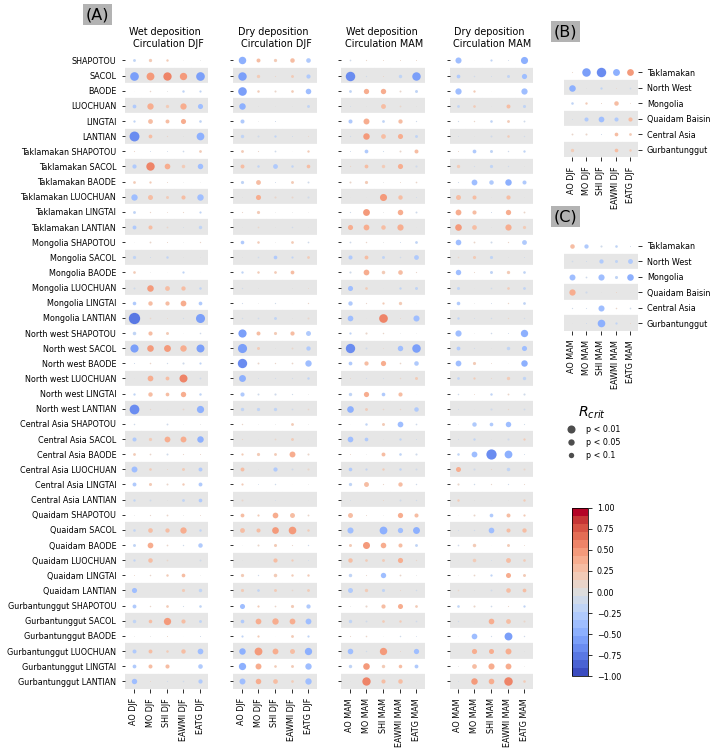

In [23]:
def plot_corrs(detrended):
    fig,ax = plt.subplots(figsize=(7.3,11.7), ncols=4, sharey=True)
    windicies = ['AO DJF','MO DJF', 'SHI DJF','EAWMI DJF', 'EATG DJF']
    sinidcies = ['AO MAM','MO MAM', 'SHI MAM','EAWMI MAM','EATG MAM']
    winter_correlation = detrended[new_column_names+windicies].corr()[windicies]
    spring_correlation = detrended[new_column_names+sinidcies].corr()[sinidcies]

    wetdep_names = [f'{s} {loc} {tag}' for s, loc, tag in product(new_regions ,locs, ['wetdep'])]
    drydep_names = [f'{s} {loc} {tag}' for s, loc, tag in product(new_regions ,locs, ['drydep'])]
    wcorr_dd = winter_correlation.drop(wetdep_names+windicies, axis=0)
    wcorr_dw = winter_correlation.drop(drydep_names+windicies, axis=0)
    scorr_dd = spring_correlation.drop(wetdep_names+sinidcies, axis=0)
    scorr_dw = spring_correlation.drop(drydep_names+sinidcies, axis=0)

    data = {'Wet deposition \n Circulation DJF': wcorr_dw,
           'Dry deposition \n Circulation DJF': wcorr_dd,
           'Wet deposition \n Circulation MAM' : scorr_dw,
           'Dry deposition \n Circulation MAM': scorr_dd}

    cmap = matplotlib.cm.get_cmap('coolwarm',21)



    for dn,axi in zip(data,ax):
        axi.set_title(dn)
        sns.heatmap(data[dn],ax=axi, cmap=cmap, vmin=-1, vmax=1,cbar=False)
        create_bubbles(data[dn],axi)
    ytickslabs = [' '.join(i.split(' ')[:-1]).strip() for i in wcorr_dd.index]
    ax[0].set_yticklabels(ytickslabs)
    ax[0].text(0.05,0.92,'(A)', transform=fig.transFigure, fontsize=16,
              bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    plt.subplots_adjust(wspace=0.3)
    ax4 = fig.add_axes([0.96,0.756,0.14,0.11])
    skeys = ['Taklamakan','North West', 'Mongolia', 'Quaidam', 'Central Asia', 'Gurbantunggut']
    emi_wintercorr = detrended[skeys+windicies].corr()[windicies]
    sns.heatmap(emi_wintercorr.drop(windicies, axis=0),ax=ax4, cmap=cmap, vmin=-1, vmax=1,cbar=False)
    create_bubbles(emi_wintercorr.drop(windicies, axis=0),ax4)
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()
    ax4.tick_params(axis='y', labelrotation = 0)
    ax4.text(0.94,0.9,'(B)', transform=fig.transFigure, 
             fontsize=16,bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))


    emi_spring = detrended[skeys+sinidcies]
    emi_springcorr = emi_spring.corr()[sinidcies]
    ax5 = fig.add_axes([0.96,0.55,0.14,0.11])
    sns.heatmap(emi_springcorr.drop(sinidcies, axis=0),ax=ax5, cmap=cmap, vmin=-1, vmax=1,cbar=False)
    create_bubbles(emi_springcorr.drop(sinidcies, axis=0),ax5)
    ax5.yaxis.set_label_position("right")
    ax5.yaxis.tick_right()
    ax5.tick_params(axis='y', labelrotation = 0)

    ax5.text(0.94,0.68,'(C)', transform=fig.transFigure, 
             fontsize=16,bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    cax=fig.add_axes([0.975,0.14,0.03,0.2])
    fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1, vmax=1),cmap=cmap),cax=cax)

    critical_correlations = { 'p < 0.01':0.537,'p < 0.05':0.423,'p < 0.1':0.360,} 
    # Taken from correlation table https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/table-of-critical-values-pearson-correlation/
    handles = [
        matplotlib.lines.Line2D([0],[i], color='0.3', marker='o',markersize=15*critical_correlations[k], linestyle='') for i, k in enumerate(critical_correlations)
        ]
    labels = [k for k in critical_correlations]

    legend = fig.legend(handles, labels, bbox_to_anchor= [1.08,0.43],loc='center right', frameon=False)
    legend.set_title('$R_{crit}$', prop=dict(size=14))
plot_corrs(detrended_silt)
if to_file:
    plt.savefig(snakemake.output.outpath_silt,bbox_inches='tight')


Strong correlation between SH and MO and EAWMI suggest that both idicies are suitable for capturing the intensitity of the winter monsoon. The AO directly influences the surface temperature rather than the siberian high. Negative AO in winter does correspond to strenghtend SHI in spring. AO spring is positively correlated with temperature gradient in spring, which means weaker temperature gradient positive AO springs.The siberian High seems to be excluded from the AO influcence on dust depostion most of the sites except for Lantian and Lingtai, which show postive correlation between SHI and dust deposition.   

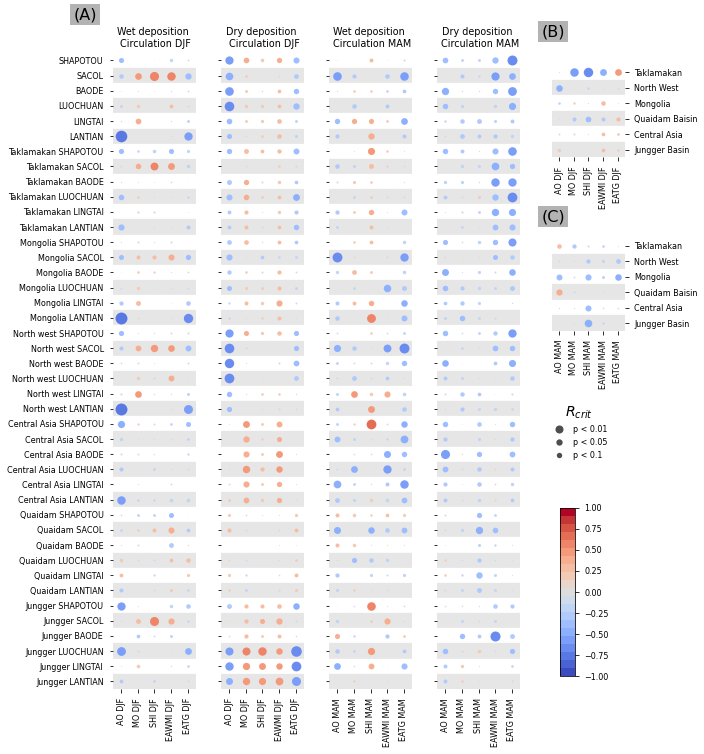

In [10]:
plot_corrs(detrended_clay)

if to_file:
    plt.savefig(snakemake.output.outpath_clay,bbox_inches='tight')